# Neural Networks - Perceptron


**Author:** Sima Adleyba  
**Date:** November 2025

**Email**: adleyba@sabanciuniv.edu

Sebastian Raschka's Deep Learning course was used as a reference.


## Perceptron
Perceptron is a type of neural network that performs binary classification that maps input features to an output decision.

Perceptron_8.avif

## Implementing Perceptron

### Data Generation, Train-Test Split

Import necessary libraries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Generate data

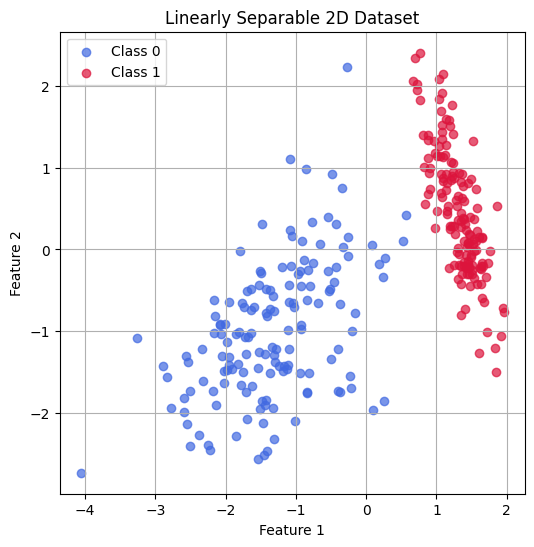

In [2]:
# two Gaussian blobs with some overlap, then rotation
n = 150
np.random.seed(42)

# class 0
A = np.random.randn(n, 2) * [0.8, 0.8]
T0 = np.array([[1.0, 0.35], [0.2, 1.0]])
mu0 = np.array([-1.3, -1.0])
class0 = A.dot(T0) + mu0

# class 1
B = np.random.randn(n, 2) * [0.8, 0.8]
T1 = np.array([[0.3, -0.35], [-0.2, 1.0]])
mu1 = np.array([1.3, 0.5])
class1 = B.dot(T1) + mu1


# stack and label
X = np.vstack([class0, class1])
y = np.hstack([np.zeros(n), np.ones(n)])

# shuffle
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# visualize
plt.figure(figsize=(6,6))
plt.scatter(X[y==0,0], X[y==0,1], color='royalblue', label='Class 0', alpha=0.7)
plt.scatter(X[y==1,0], X[y==1,1], color='crimson', label='Class 1', alpha=0.7)
plt.title('Linearly Separable 2D Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Train-test split

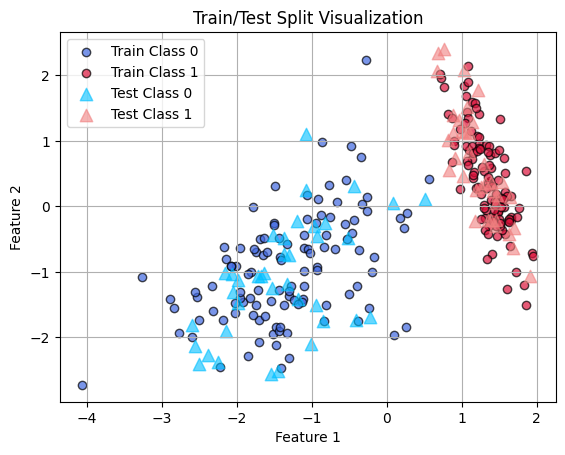

In [3]:
# split
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)


# convert data to PyTorch tensors
X_train = torch.tensor(X_train_temp, dtype=torch.float32)
y_train = torch.tensor(y_train_temp, dtype=torch.float32)
X_test  = torch.tensor(X_test_temp, dtype=torch.float32)
y_test  = torch.tensor(y_test_temp, dtype=torch.float32)


# training points
plt.scatter(
    X_train[y_train==0, 0], X_train[y_train==0, 1],
    color='royalblue', label='Train Class 0', alpha=0.7, edgecolors='k'
)
plt.scatter(
    X_train[y_train==1, 0], X_train[y_train==1, 1],
    color='crimson', label='Train Class 1', alpha=0.7, edgecolors='k'
)

# test points
plt.scatter(
    X_test[y_test==0, 0], X_test[y_test==0, 1],
    color='deepskyblue', label='Test Class 0', alpha=0.6, marker='^', s=80
)
plt.scatter(
    X_test[y_test==1, 0], X_test[y_test==1, 1],
    color='lightcoral', label='Test Class 1', alpha=0.6, marker='^', s=80
)

plt.title('Train/Test Split Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

### Define the perceptron model

In [5]:
class Perceptron():
    def __init__(self, num_features, learning_rate):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32)
        self.bias = torch.zeros(1, dtype=torch.float32)
        self.learning_rate = learning_rate
        self.boundaries = []


    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias # performs linear combination: y = x * w + b
        predictions = torch.where(linear > 0., 1, 0) # apply step function: output > 0 -> class 1, else class 0
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs):
        for e in range(epochs):

            for i in range(y.shape[0]):
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += self.learning_rate * (errors * x[i]).reshape(self.num_features, 1)
                self.bias += self.learning_rate * errors

            # compute accuracy at end of each epoch
            acc = self.evaluate(x, y)
            print(f"Epoch {e+1}/{epochs} — Training accuracy: {acc*100:.2f}%")

            # save boundary line parameters
            self.boundaries.append((self.weights.clone().cpu(), self.bias.clone().cpu()))


    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

### Train the perceptron

In [6]:
# initialize model
ppn = Perceptron(num_features=2, learning_rate=0.001)

# train
ppn.train(X_train, y_train, epochs=5)

# evaluate on test set
test_acc = ppn.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

# print model parameters
print("\nModel parameters:")
print(f"Weights: {ppn.weights}")
print(f"Bias: {ppn.bias}")

Epoch 1/5 — Training accuracy: 99.11%
Epoch 2/5 — Training accuracy: 97.78%
Epoch 3/5 — Training accuracy: 100.00%
Epoch 4/5 — Training accuracy: 100.00%
Epoch 5/5 — Training accuracy: 100.00%

Test accuracy: 100.00%

Model parameters:
Weights: tensor([[0.0038],
        [0.0002]])
Bias: tensor([-0.0030])


### Visualization

Boundary evolution

/tmp/ipython-input-1904238791.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(b.numpy())


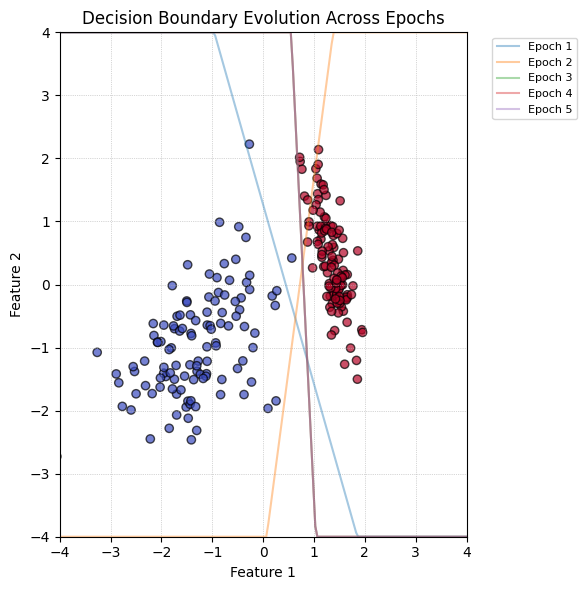

In [7]:
def plot_boundary_evolution(model, X_train, y_train, lim=4):
    plt.figure(figsize=(6,6))

    # data scatter
    plt.scatter(X_train[:,0], X_train[:,1],
                c=y_train, cmap=plt.cm.coolwarm,
                edgecolors='k', alpha=0.7)

    # x-range restricted to data range
    x_vals = np.linspace(-lim, lim, 200)

    for i, (w, b) in enumerate(model.boundaries):
        w = w.numpy().flatten()
        b = float(b.numpy())

        y_vals = -(w[0]*x_vals + b)/w[1]

        # clip to visible region
        y_vals = np.clip(y_vals, -lim, lim)
        plt.plot(x_vals, y_vals,
                 alpha=0.4, lw=1.5,
                 label=f'Epoch {i+1}')

    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary Evolution Across Epochs")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# run
plot_boundary_evolution(ppn, X_train, y_train)

Final decision boundary

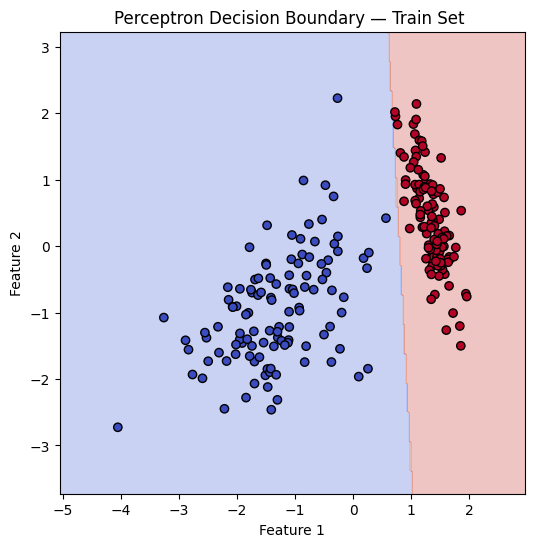

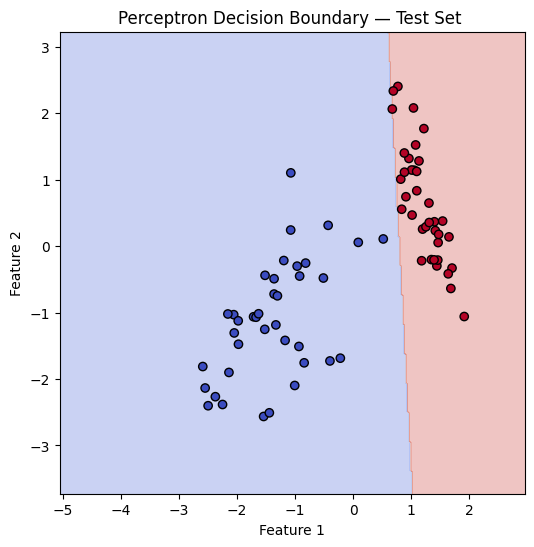

In [8]:
def plot_decision_boundary(model, X_train, y_train, X_test, y_test, title_suffix=""):
    # Create a mesh grid over feature space
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Flatten and combine grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=model.weights.device)

    # Forward pass (no gradient)
    with torch.no_grad():
        Z = model.forward(grid_tensor).cpu().numpy().reshape(xx.shape)

    # --- Plot train set ---
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(f"Perceptron Decision Boundary — Train Set {title_suffix}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

    # --- Plot test set ---
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(f"Perceptron Decision Boundary — Test Set {title_suffix}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Run
plot_decision_boundary(ppn, X_train, y_train, X_test, y_test)